### Learning LSTM

    Author: 彭日骏
    Time: 2025/11/04
Code a LSTM to do a **Stock prices prediction Project**

---

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### 数据读入和检查

---

In [2]:
data_file = './data/DIS.csv'

df = pd.read_csv(data_file, header=None, index_col=None, parse_dates=True)

df.head()

,0,1,2,3,4,5,6
0,1996-12-31,23.011177,23.175543,22.805719,22.928993,17.804647,2719200
1,1997-01-02,22.928993,22.970085,21.942801,22.148258,17.198397,8115400
2,1997-01-03,22.394806,22.805719,22.394806,22.764629,17.677013,4650000
3,1997-01-06,22.764629,22.928993,22.559172,22.682446,17.613201,3623300
4,1997-01-07,22.682446,22.682446,22.435898,22.641354,17.581289,3606200


In [3]:
from sklearn.preprocessing import MinMaxScaler

dataset_pre = df[5].values
dataset = dataset_pre.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

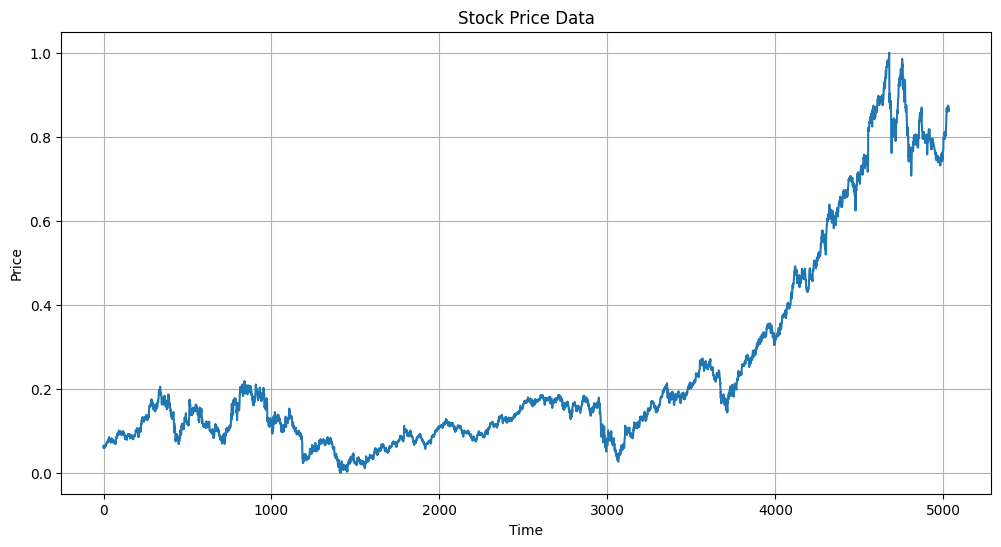

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(dataset)
plt.title('Stock Price Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid()
plt.show()

#### 数据预处理Dataloader

---

In [5]:
from torch.utils.data import TensorDataset, DataLoader

def create_seq_loader(input_data, tw, batchsize=100, is_shuffle=True):
    '''
    Parameters:
        input_data(numpy list float): long inputs'time sequences
        tw(int): time_window, A train sequence length 
        batch_size(int)
        is_shuffle(bool)
    Return:
        dataloader(PyTorch Tensor float)
    '''
    in_seq = []
    out_seq = []
    for i in range(len(input_data) - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1]
        in_seq.append(train_seq)
        out_seq.append(train_label)

    X_np = np.array(in_seq)
    Y_np = np.array(out_seq).reshape(-1, 1)

    X_tensor = torch.tensor(X_np, dtype=torch.float32)
    Y_tensor = torch.tensor(Y_np, dtype=torch.float32)

    dataset = TensorDataset(X_tensor, Y_tensor)
    dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=is_shuffle)
    
    return dataloader


In [6]:
L = len(dataset)
train_size = int (L * 0.7)
test_size = L - train_size

train_data, test_data = dataset[0:train_size, :], dataset[train_size:L, :]

tw = 10
batch_size = 64

train_loader = create_seq_loader(train_data, tw, batch_size, is_shuffle=True)
test_loader = create_seq_loader(test_data, tw, batch_size, is_shuffle=False)

#### LSTM 模型训练

---

In [7]:
class stock_predict_lstm(nn.Module):

    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):

        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True) # 匹配 (batch_size, , ) 在前的数据格式
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):

        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)

        lstm_out, _ = self.lstm(input_seq, (h0, c0))

        # 只有最后的时间步是有意义的
        predictions = self.linear(lstm_out[:, -1, :])

        return predictions

model = stock_predict_lstm().to(device)

In [8]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
train_losses = []

model.train()

for i in range(epochs):
    epoch_loss = 0.0
    for seq, labels in train_loader:
        seq, labels = seq.to(device), labels.to(device)

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    if (i+1) % 10 == 0:
        print(f'Epoch: {i+1:3d}/{epochs}, Loss: {avg_epoch_loss:.6f}')

print("Train Finish")

Epoch:  10/100, Loss: 0.000072
Epoch:  20/100, Loss: 0.000063
Epoch:  30/100, Loss: 0.000049
Epoch:  40/100, Loss: 0.000041
Epoch:  50/100, Loss: 0.000038
Epoch:  60/100, Loss: 0.000032
Epoch:  70/100, Loss: 0.000030
Epoch:  80/100, Loss: 0.000027
Epoch:  90/100, Loss: 0.000025
Epoch: 100/100, Loss: 0.000027
Train Finish


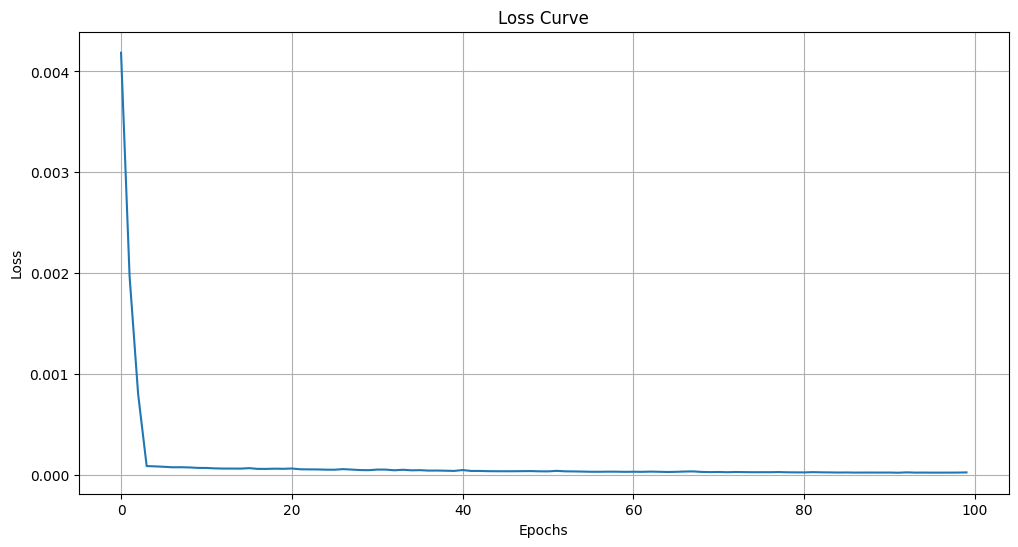

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

#### 模型评估

---

In [10]:
model.eval()
test_predictions = []
actual_values = []

with torch.no_grad():
    for seq, labels in test_loader:
        seq = seq.to(device)

        preds = model(seq)

        test_predictions.extend(preds.cpu().numpy().flatten())
        actual_values.extend(labels.numpy().flatten())

test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
actual_values_inv = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1))

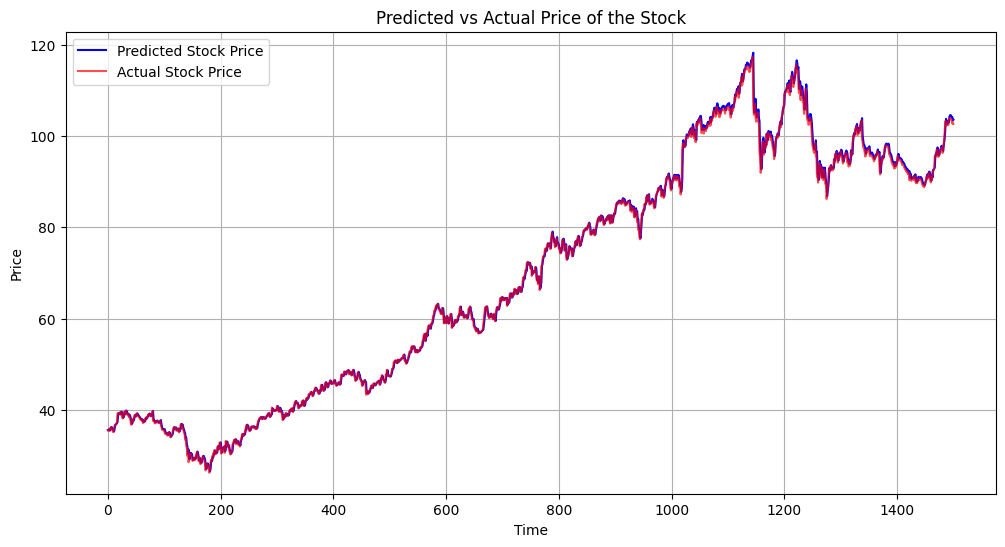

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(test_predictions_inv, label='Predicted Stock Price', color='Blue')
plt.plot(actual_values_inv, label='Actual Stock Price', color='red', alpha=0.7) # ---???What is alpha?
plt.title('Predicted vs Actual Price of the Stock')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()